# Differential Privacy Example

The following is a simulation of a __differentially private__ survey of _n_ individuals. The survey consists of _q_ yes-or-no questions, where "yes" is represented as 1, and "no" as 0. When the answers are recorded, laplacian noise is added to ensure the privacy of each individual. Then, we use PyMC3 to infer the proportions of individuals who answered "yes" for each question, without actually knowing any of the true answers.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pymc3 as pm
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.3


In [2]:
%matplotlib inline
plt.style.use('seaborn-darkgrid')
np.random.seed(1234)

In [3]:
# n is the number of people who participate in the survey
n = 1000

# q is the number of questions on the survey
q = 10

# y is the vector of true proportions of "yes" answers for each question
y = np.random.uniform(size=q)

# Initialize and populate the true survey results
true_results = np.zeros((n, q))
for i in range(q):
    true_results[:int(n * y[i]), i] = 1

In [4]:
# sensitivity is the max difference that a single answer can make
sensitivity = 1

# epsilon is the privacy budget (smaller is more private)
epsilon = 1

# b is the scale of the laplacian noise
b = sensitivity / epsilon

# Make some noise
noise = np.random.laplace(scale=b, size=(n, q))

# Add noise
noisy_results = true_results + noise

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [inferred_y_interval__]
100%|██████████| 5500/5500 [00:14<00:00, 389.06it/s]


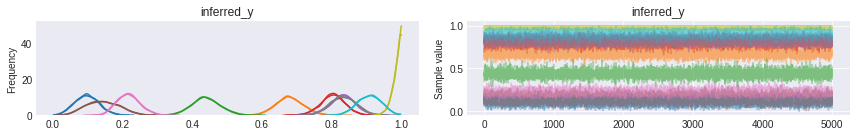

In [5]:
model = pm.Model()

with model:
    # Start with a uniform prior
    inferred_y = pm.Uniform('inferred_y', lower=0, upper=1, shape=q)
    
    # Treat y as the center of of the noise
    observed_noise = pm.Laplace('observed_noise', mu=inferred_y, b=b, shape=q, observed=noisy_results)
    
    # Run the simulation
    trace = pm.sample(5000)
    pm.traceplot(trace);

In [6]:
y_hat = pm.find_MAP(model=model)['inferred_y']
error = y - y_hat
error

logp = -17,657, ||grad|| = 0.31824: 100%|██████████| 45/45 [00:00<00:00, 1365.40it/s]  


array([ 0.09194026, -0.05377892,  0.00225819, -0.01607696, -0.0533224 ,
        0.13060287,  0.06222906, -0.02549113, -0.04185786, -0.03017537])